In [1]:
from preprocessing import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import mne
import os


In [2]:
FILE_PATH = './../../data/raw/Data_npy/DATA_001_Trial1.npy'
data_loader = DataLoader(FILE_PATH)
raws_left_arm = data_loader.get_raws(side='G')
raws_right_arm = data_loader.get_raws(side='D')
raws_left_arm.ch_names

FMIN = 1
FMAX = 40
EPOCHS_TMIN = -2
EPOCHS_TMAX = 2


RANDOM_STATE = 42


CHANNELS = ['F3', 'C3', 'P3', 'Fz', 'Cz', 'Pz', 'F4', 'C4', 'P4']

In [3]:
def acc_to_movement(raw):
    acc = raw['AC'][0][0]
    new_acc_smoothed = np.zeros(acc.shape)
    mean = np.mean(acc)
    new_acc_smoothed[acc > mean] = 1
    movement_new = np.zeros(new_acc_smoothed.shape)
    movement_new[1:] = new_acc_smoothed[:-1]
    movement_new = movement_new - new_acc_smoothed
    movement_new[0] = 0
    movement_new[movement_new == -1] = 2
    return movement_new

In [76]:
data_loader = DataLoader(FILE_PATH)
raws_left_arm = data_loader.get_raws(side='G')
mouvement_all = acc_to_movement(raws_left_arm).reshape(1, -1)
info = mne.create_info(ch_names=['movement_all'], sfreq=1024)
raw_new = mne.io.RawArray(mouvement_all, info)
raws_left_arm.add_channels([raw_new], force_update_info=True)


<RawArray | 70 x 237960 (232.4 s), ~127.2 MB, data loaded>

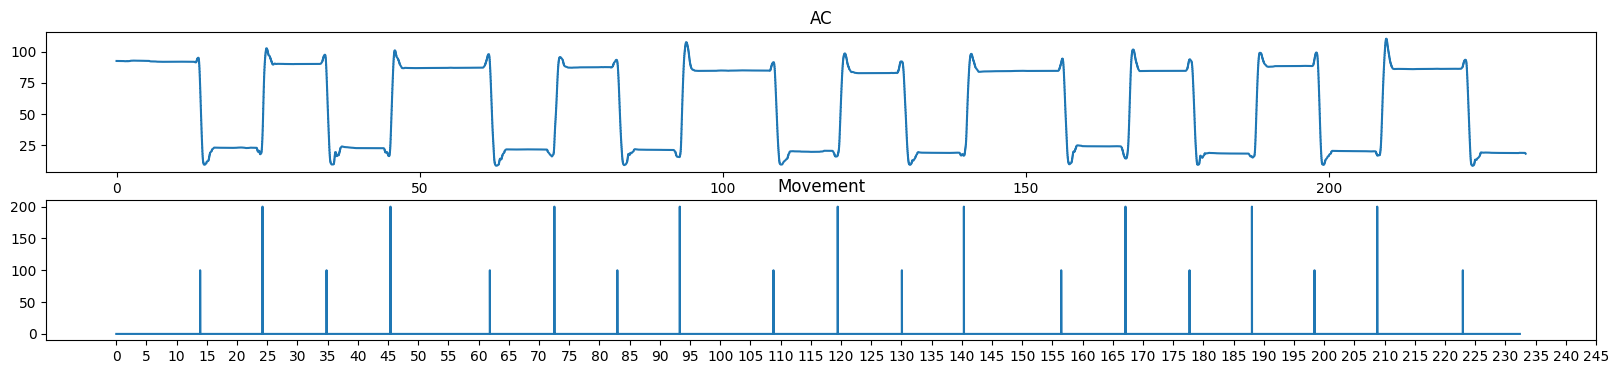

In [77]:
fig, axes = plt.subplots(2, 1, figsize=(20, 4))
axes[0].plot(raws_left_arm.times, raws_left_arm['AC'][0][0])
axes[0].set_title('AC')
axes[1].plot(raws_left_arm.times, raws_left_arm['movement_all'][0][0]*100)
axes[1].set_title('Movement')
axes[1].xaxis.set_ticks(np.arange(0, 250, 5))
plt.show()

In [81]:
events = mne.find_events(raws_left_arm, stim_channel=['movement_all'])
picks = mne.pick_types(raws_left_arm.info, eeg=True, stim=False)
epochs = mne.Epochs(raws_left_arm, events, tmin=EPOCHS_TMIN, tmax=EPOCHS_TMAX, picks=picks, baseline=None, preload=True)

In [83]:
epochs.events[:, -1]

array([1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1],
      dtype=int64)

In [4]:
FMIN = 1
FMAX = 40
EPOCHS_TMIN = -1
EPOCHS_TMAX = 3

EPOCHS_EMPTY_FROM_MVT_TMINS = -7

WINDOW_DURATION = 0.5
STEP_DURATION = 0.2
LABEL_START = -EPOCHS_TMIN + 0 
LABEL_END = -EPOCHS_TMIN + 2

RANDOM_STATE = 42


CHANNELS = ['F3', 'C3', 'P3', 'Fz', 'Cz', 'Pz', 'F4', 'C4', 'P4']

In [36]:
def preproc(file_path_list):
    labels = np.zeros(0)
    epochs_data_list = []
    signal = 0
    for file in file_path_list:
        data_loader = DataLoader(file)

        for side in ['D', 'G']:
            raws = data_loader.get_raws(side=side)
            
            if raws is None:
                continue

            # adding movement channel
            mouvement_all = acc_to_movement(raws).reshape(1, -1)
            info = mne.create_info(ch_names=['movement_all'], sfreq=1024)
            raw_new = mne.io.RawArray(mouvement_all, info)
            raws.add_channels([raw_new], force_update_info=True)

            #debbug
            """
            fig, axes = plt.subplots(4, 1, figsize=(20, 8))
            axes[0].plot(raws.times, raws['AC'][0][0])
            axes[0].set_title('AC')
            axes[1].plot(raws.times, raws['movement_all'][0][0]*100)
            axes[1].set_title('Movement')
            axes[2].plot(raws.times, raws['VAC'][0][0])
            axes[2].set_title('VAC')
            axes[3].plot(raws.times, raws['AC3d'][0][0])
            axes[3].set_title('VAC')
            axes[3].xaxis.set_ticks(np.arange(0, 250, 5))
            plt.show()
            """

            # filtering
            raws.filter(FMIN, FMAX, fir_design='firwin')

            # creating epochs over flexion and extension of the arm (movement_all)
            events = mne.find_events(raws, stim_channel=['movement_all'])
            print(raws['movement_all'][0][0][raws['movement_all'][0][0] > 0])
            picks = mne.pick_types(raws.info, eeg=True, stim=False)
            print(f'events shape: {events.shape}')
            print(raws)
            epochs = mne.Epochs(raws, events, tmin=EPOCHS_TMIN, tmax=EPOCHS_TMAX, picks=picks, baseline=None, preload=True)
            epochs_data = epochs.get_data()
            labels = np.concatenate((labels, epochs.events[:, -1]), axis=0)

            # creating artificial epoch when no movement
            epochs_no_mvt = mne.Epochs(raws, events, tmin=EPOCHS_EMPTY_FROM_MVT_TMINS, tmax=EPOCHS_EMPTY_FROM_MVT_TMINS+EPOCHS_TMAX-EPOCHS_TMIN, 
                                       picks=picks, baseline=None, preload=True)
            epochs_no_mvt_data = epochs_no_mvt.get_data()
            epochs_data = np.concatenate((epochs_data, epochs_no_mvt_data), axis=0)
            labels = np.concatenate((labels, np.zeros(epochs_no_mvt_data.shape[0])), axis=0)

            epochs_data_list.append(epochs_data)
            print(f'signal: {signal}')
            print(f'epochs_data_list shape: {epochs_data_list[-1].shape}')
            print(f'epochs_data: {epochs_data.shape}')
            print(f'labels shape: {labels.shape}')
            signal += 1

    epochs_data_all = np.concatenate(epochs_data_list, axis=0)
    
    return epochs_data_all, labels

In [35]:
del epochs_data, labels

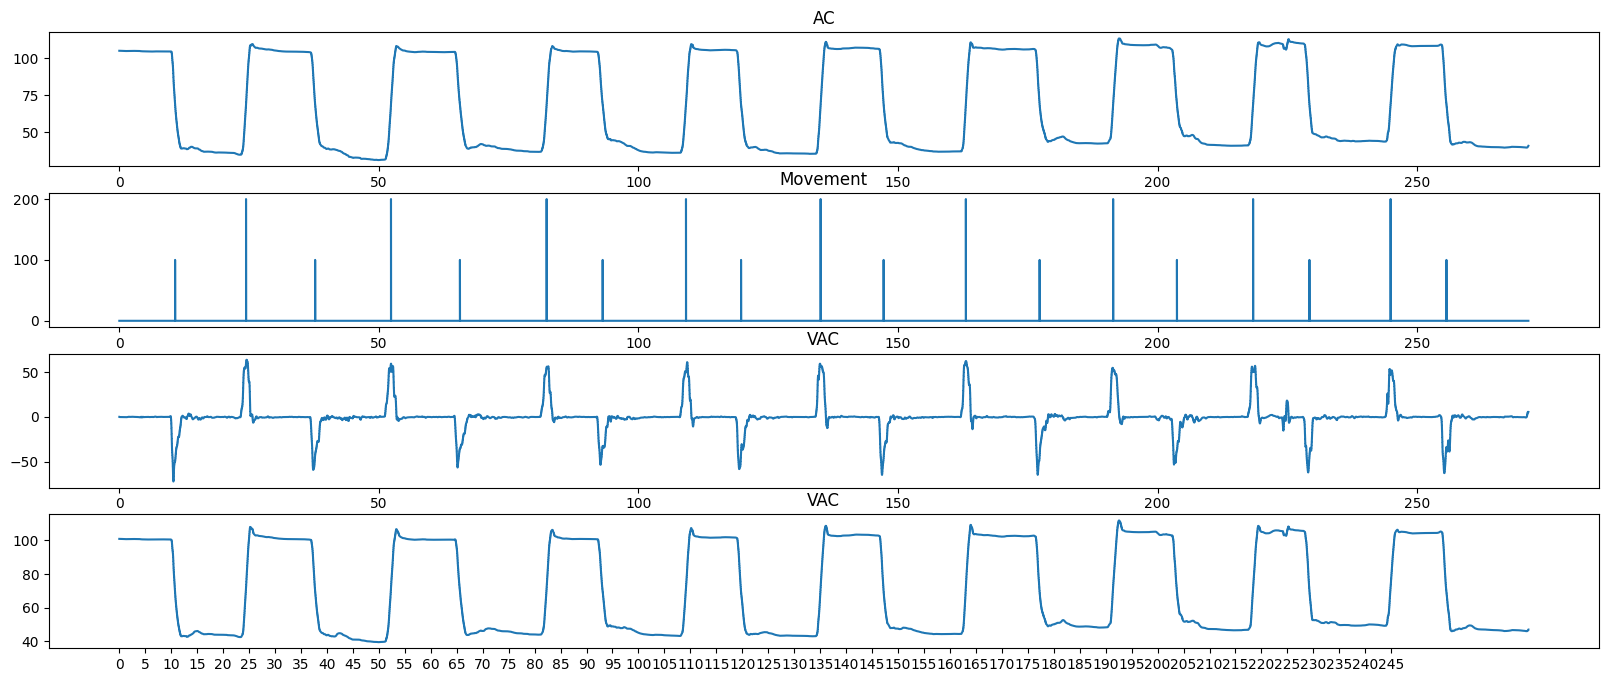

[1. 2. 1. 2. 1. 2. 1. 2. 1. 2. 1. 2. 1. 2. 1. 2. 1. 2. 1.]
events shape: (19, 3)
<RawArray | 70 x 277936 (271.4 s), ~148.5 MB, data loaded>
signal: 0
epochs_data_list shape: (38, 64, 4097)
epochs_data: (38, 64, 4097)
labels shape: (38,)


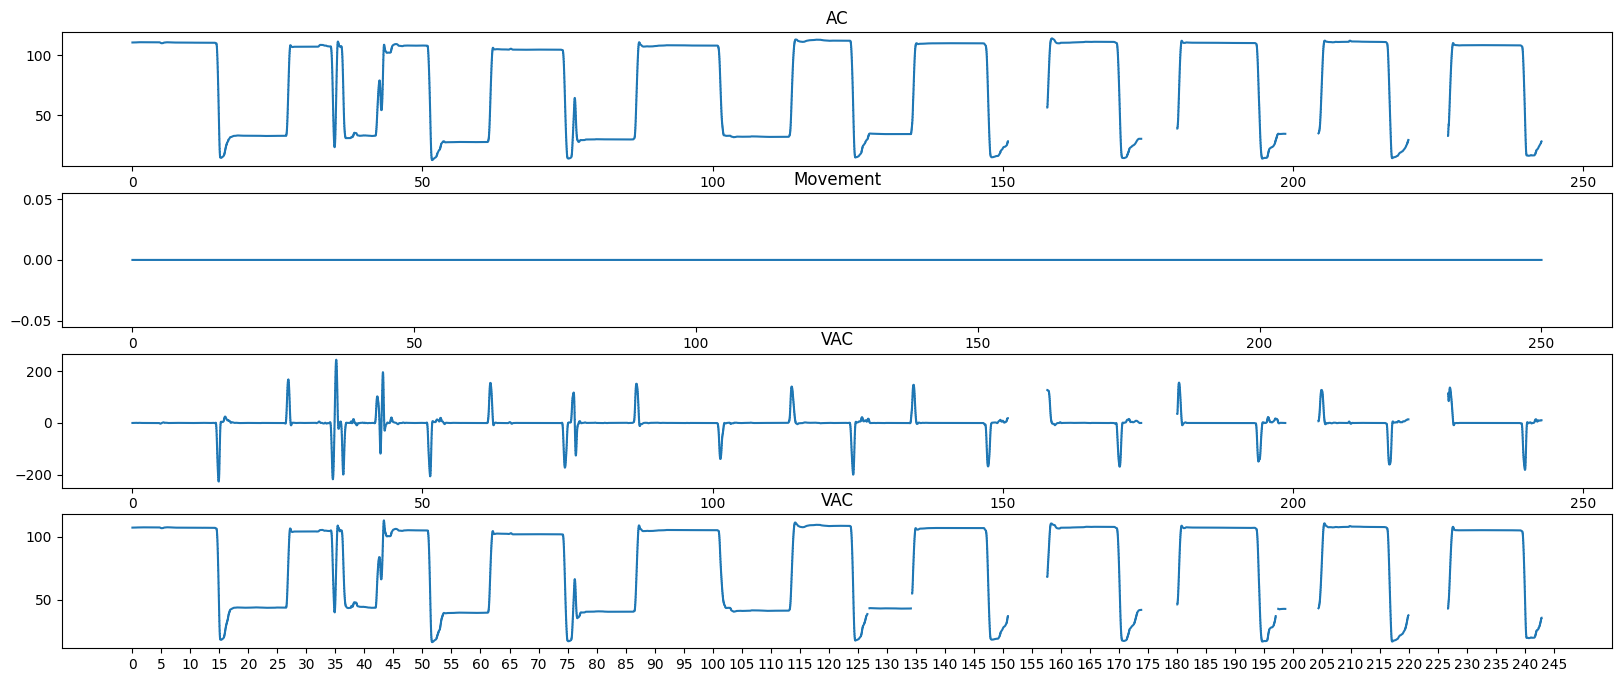

[]
events shape: (0, 3)
<RawArray | 70 x 256034 (250.0 s), ~136.8 MB, data loaded>


ValueError: zero-size array to reduction operation maximum which has no identity

In [37]:
FOLDER_PATH = './../../data/raw/Data_npy/'
FILE_PATH_LIST = [FOLDER_PATH + file_path for file_path in os.listdir(FOLDER_PATH) if file_path.endswith('.npy')]
epochs_data, labels = preproc(FILE_PATH_LIST[5:6])

In [10]:
epochs_data.shape, labels.shape

((336, 64, 4097), (336,))

In [11]:
labels_unif = labels.copy()
labels_unif[labels_unif == 2] = 1

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit

In [13]:
def train_evaluate(epochs, labels, pipeline):

    ALL_CHANELS = ['AF3','AF4','AF7','AF8','AFz','C1','C2','C3','C4','C5','C6','CP1','CP2','CP3','CP4','CP5','CP6','CPz','Cz','F1','F2','F3','F4','F5','F6','F7','F8','FC1','FC2','FC3','FC4','FC5','FC6','FCz','FT7','FT8','Fp1','Fp2','Fpz','Fz','Iz','O1','O2','Oz','P1','P2','P3','P4','P5','P6','P7','P8','P9','P10','PO3','PO4','PO7','PO8','POz','Pz','T7','T8','TP7','TP8','AC','VAC','AC3d','VAC3d', 'movement']
    channel_idx = [ALL_CHANELS.index(channel) for channel in CHANNELS]
    print(channel_idx)


    cv = ShuffleSplit(4, test_size=0.2, random_state=RANDOM_STATE)
    #data_train, data_test, labels_train, labels_test = train_test_split(epochs, labels, test_size=0.2, random_state=RANDOM_STATE)

    scores = cross_val_score(pipeline, epochs, labels, cv=cv, n_jobs=-1, scoring='balanced_accuracy')
    print(scores.mean())

    return scores.mean()

In [14]:
epochs_data.shape, labels_unif.shape

((336, 64, 4097), (336,))

In [15]:
# transform labels type in int
labels_unif.astype(int)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from mne.decoding import CSP

csp = CSP(n_components=4, reg='ledoit_wolf', log=True, norm_trace=False)
clf = LinearDiscriminantAnalysis()
pipeline = Pipeline([('CSP', csp), ('LDA', clf)])

new_epochs_data = epochs_data[:,[21, 7, 46, 39, 18, 59, 22, 8, 47],:]

scores = train_evaluate(new_epochs_data, labels_unif, pipeline)

[21, 7, 46, 39, 18, 59, 22, 8, 47]


ValueError: 
All the 4 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "d:\Documents\Scolaires\SUPAERO\3A\PIE\PIE_2023\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\Documents\Scolaires\SUPAERO\3A\PIE\PIE_2023\venv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "d:\Documents\Scolaires\SUPAERO\3A\PIE\PIE_2023\venv\lib\site-packages\sklearn\pipeline.py", line 423, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "d:\Documents\Scolaires\SUPAERO\3A\PIE\PIE_2023\venv\lib\site-packages\sklearn\pipeline.py", line 377, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "d:\Documents\Scolaires\SUPAERO\3A\PIE\PIE_2023\venv\lib\site-packages\joblib\memory.py", line 353, in __call__
    return self.func(*args, **kwargs)
  File "d:\Documents\Scolaires\SUPAERO\3A\PIE\PIE_2023\venv\lib\site-packages\sklearn\pipeline.py", line 957, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "d:\Documents\Scolaires\SUPAERO\3A\PIE\PIE_2023\venv\lib\site-packages\mne\decoding\csp.py", line 249, in fit_transform
    return super().fit_transform(X, y=y, **fit_params)
  File "d:\Documents\Scolaires\SUPAERO\3A\PIE\PIE_2023\venv\lib\site-packages\mne\decoding\mixin.py", line 31, in fit_transform
    return self.fit(X, y, **fit_params).transform(X)
  File "d:\Documents\Scolaires\SUPAERO\3A\PIE\PIE_2023\venv\lib\site-packages\mne\decoding\csp.py", line 187, in fit
    covs, sample_weights = self._compute_covariance_matrices(X, y)
  File "d:\Documents\Scolaires\SUPAERO\3A\PIE\PIE_2023\venv\lib\site-packages\mne\decoding\csp.py", line 528, in _compute_covariance_matrices
    cov, weight = cov_estimator(X[y == this_class])
  File "d:\Documents\Scolaires\SUPAERO\3A\PIE\PIE_2023\venv\lib\site-packages\mne\decoding\csp.py", line 544, in _concat_cov
    cov = _regularized_covariance(
  File "d:\Documents\Scolaires\SUPAERO\3A\PIE\PIE_2023\venv\lib\site-packages\mne\cov.py", line 2120, in _regularized_covariance
    cov = _compute_covariance_auto(
  File "d:\Documents\Scolaires\SUPAERO\3A\PIE\PIE_2023\venv\lib\site-packages\mne\cov.py", line 1259, in _compute_covariance_auto
    RawArray(data.T, info, copy=None, verbose=_verbose_safe_false()),
  File "<decorator-gen-246>", line 10, in __init__
  File "d:\Documents\Scolaires\SUPAERO\3A\PIE\PIE_2023\venv\lib\site-packages\mne\io\array\array.py", line 79, in __init__
    raise ValueError(
ValueError: data copying was not requested by copy=None but it was required to get to double floating point precision


In [19]:
new_epochs_data.dtype

dtype('float64')

In [18]:
from pyriemann.estimation import Covariances
from pyriemann.tangentspace import TangentSpace
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

cov = Covariances(estimator='oas')
ts = TangentSpace()
ss = StandardScaler()
rf = RandomForestClassifier() 
pipeline = Pipeline([('Cov', cov), ('TangentSpace', ts), ('StandardScaler', ss), ('RandomForestClassifier', rf)])

new_epochs_data = epochs_data[:,[21, 7, 46, 39, 18, 59, 22, 8, 47],:]

scores = train_evaluate(epochs_data, labels_unif, pipeline)

[21, 7, 46, 39, 18, 59, 22, 8, 47]
0.9019453220058058
